# Basis regressieanalyse

In dit notitieboekje werken we aan regressie. We gebruiken een subset van de student_performance_data met ontbrekende waarden.

We gaan ervan uit dat de doelvariabele G3 is en we voeren een regressieanalyse uit met behulp van de onafhankelijke variabelen noemen, G3 waarnaar we in dit notitieboek verwijzen als de afhankelijke variabele of de doelvariabele.

1. Data laden
2. Bereid de gegevens voor
3. Regressie analyse
4. Identificeer de beste voorbewerking combinatie voor regressie
5. Controleer andere modellen voor regressie

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce

import scipy.stats as stats

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.api as sm
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin

# 1) Laad de gegevens en scheid de kolommen

Uiteraard begin ik met het inladen van de data

In [2]:
student_performance_data = pd.read_csv("student_performance_basis.csv")
student_performance_data

,age,sex,Medu,Fedu,reason,absences,G1,G3
0,18,F,4,4,course,6,5,6
1,17,F,1,1,course,4,5,6
2,15,F,1,1,other,10,7,10
3,15,F,4,2,home,2,15,15
4,16,F,3,3,home,4,6,10
...,...,...,...,...,...,...,...,...
1039,19,F,2,3,course,4,10,10
1040,18,F,3,1,course,4,15,16
1041,18,F,1,1,course,6,11,9
1042,17,M,3,1,course,6,10,10


In [3]:
student_performance_data.head(10)

,age,sex,Medu,Fedu,reason,absences,G1,G3
0,18,F,4,4,course,6,5,6
1,17,F,1,1,course,4,5,6
2,15,F,1,1,other,10,7,10
3,15,F,4,2,home,2,15,15
4,16,F,3,3,home,4,6,10
5,16,M,4,3,reputation,10,15,15
6,16,M,2,2,home,0,12,11
7,17,F,4,4,home,6,6,6
8,15,M,3,2,home,0,16,19
9,15,M,3,4,home,0,14,15


In [4]:
student_performance_data.columns

Index(['age', 'sex', 'Medu', 'Fedu', 'reason', 'absences', 'G1', 'G3'], dtype='object')

In [5]:
student_performance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       1044 non-null   int64 
 1   sex       1044 non-null   object
 2   Medu      1044 non-null   int64 
 3   Fedu      1044 non-null   int64 
 4   reason    1044 non-null   object
 5   absences  1044 non-null   int64 
 6   G1        1044 non-null   int64 
 7   G3        1044 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 65.4+ KB


#### missing values

We zien hieronder dat er geen missing values in de dataset zitten. Wat heel fijn is om verder mee te werken

In [6]:
student_performance_data.isnull().sum()

age         0
sex         0
Medu        0
Fedu        0
reason      0
absences    0
G1          0
G3          0
dtype: int64

### Dataset Beschrijving
De dataset bevat de volgende variabelen:

- **Leeftijd (age):** De leeftijd van het individu.
- **Geslacht (sex):** Het geslacht van het individu.
- **Moeder Onderwijs (Medu):** Het niveau van onderwijs van de moeder.
- **Vader Onderwijs (Fedu):** Het niveau van onderwijs van de vader.
- **Reden (reason):** De reden voor het kiezen van de school.
- **Afwezigheden (absences):** Het aantal gemiste schooldagen.
- **G1 (Eerste termijn cijfer):** Het cijfer behaald in de eerste termijn.
- **G3 (Eindcijfer):** Het uiteindelijke cijfer aan het einde van het schooljaar.

### Data Dictionary

Laten we beginnen met het bekijken van de data dictionary om een beter begrip te krijgen van de variabelen in de dataset.

| Variabele naam | Datatype | Numeriek/Categorisch | Soort variabele | Toelichting |
|----------------|----------|-----------------------|-----------------|-------------|
| age            | Integer  | Numeriek              | Ratio           | Leeftijd van het individu |
| sex            | String   | Categorisch          | Nominaal        | Geslacht van het individu ('M' of 'V') |
| Medu           | Integer  | Categorisch              | Ordinaal        | Niveau van moeder's onderwijs: 0 (geen) tot 4 (hoger onderwijs) |
| Fedu           | Integer  | Categorisch              | Ordinaal        | Niveau van vader's onderwijs: 0 (geen) tot 4 (hoger onderwijs) |
| reason         | String   | Categorisch          | Nominaal        | Reden voor het kiezen van de school: 'dichtbij', 'school', 'reputatie', 'andere' |
| absences       | Integer  | Numeriek              | Ratio           | Aantal gemiste schooldagen |
| G1             | Integer  | Numeriek              | Ratio           | Cijfer behaald in de eerste termijn |
| G3             | Integer  | Numeriek              | Ratio           | Eindcijfer aan het einde van het schooljaar |


In [7]:
afhankelijke_var = ["G1", "G3"]
categorisch_var= ["Medu", "Fedu", "reason", "sex"] 
numeriek_var = ["age", "absences"]

Hieronder heb ik een functie geschreven die kijkt welke waardes target encoding nodig hebben.

In [8]:
target_encoded_features = []

threshold_for_target_encoding = 5

for col in categorisch_var:
    if student_performance_data[col].nunique() < threshold_for_target_encoding:
        target_encoder = TargetEncoder()
        student_performance_data[col] = target_encoder.fit_transform(student_performance_data[col].astype(str), 
                                                                     student_performance_data['G3'])
        target_encoded_features.append(col)

print("Categorische variabelen met target encoding:")
print(target_encoded_features)

Categorische variabelen met target encoding:
['reason', 'sex']


# Opdracht 2: Gegevensvoorbewerking

Op dit punt bereid je de gegevens voor zodat je ze later kunt gebruiken voor regressie. Hieronder ga ik de reason en sex waardes target encoden zodat ze beide een INT waarde gaan hebben in plaats van String

In [9]:
class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_encode):
        self.columns_to_encode = columns_to_encode
        self.label_encoders = {}

    def fit(self, X, y=None):
        for column in self.columns_to_encode:
            le = LabelEncoder()
            le.fit(X[column])
            self.label_encoders[column] = le
        return self

    def transform(self, X):
        X_encoded = X.copy()
        for column, le in self.label_encoders.items():
            X_encoded[column] = le.transform(X[column])
        return X_encoded

In [10]:
custom_encoder = CustomLabelEncoder(columns_to_encode=['sex', 'reason'])

custom_encoder.fit(student_performance_data)

encoded_data = custom_encoder.transform(student_performance_data)

print(encoded_data.head(20))

    age  sex  Medu  Fedu  reason  absences  G1  G3
0    18    1     4     4       1         6   5   6
1    17    1     1     1       1         4   5   6
2    15    1     1     1       0        10   7  10
3    15    1     4     2       2         2  15  15
4    16    1     3     3       2         4   6  10
5    16    0     4     3       3        10  15  15
6    16    0     2     2       2         0  12  11
7    17    1     4     4       2         6   6   6
8    15    0     3     2       2         0  16  19
9    15    0     3     4       2         0  14  15
10   15    1     4     4       3         0  10   9
11   15    1     2     1       3         4  10  12
12   15    0     4     4       1         2  14  14
13   15    0     4     3       1         2  10  11
14   15    0     2     2       2         0  14  16
15   16    1     4     4       2         4  14  14
16   16    1     4     4       3         6  13  14
17   16    1     3     3       3         4   8  10
18   17    0     3     2       

Alles is omgezet naar int. Nu kunnen we verder kijken en betere analyses uitvoeren met de data

# Opdracht 3: Regressieanalyse

Ik begin met het bekijken van de relaties tussen G3 en alle andere variabelen met een corr matrix.

In [11]:
correlation_matrix = encoded_data.corr()
print(correlation_matrix['G3'].sort_values(ascending=False))

G3          1.000000
G1          0.809142
Medu        0.201472
Fedu        0.159796
reason      0.123221
sex         0.031472
absences   -0.045671
age        -0.125282
Name: G3, dtype: float64


- G3 en G1 (eindcijfers en cijfers voor de eerste termijn): Positieve sterke correlatie (0.809142): Dit betekent dat mijn eindcijfers sterk samenhangen met mijn cijfers voor de eerste termijn. Als mijn cijfers voor de eerste termijn goed zijn, is de kans groot dat mijn eindcijfers ook hoog zullen zijn.


- G3 en Medu (opleidingsniveau moeder): Positieve matige correlatie (0.201472): Er lijkt een matige positieve relatie te zijn tussen het opleidingsniveau van mijn moeder en mijn eindcijfers. Dit suggereert dat hoger opgeleide moeders mogelijk verband houden met betere eindcijfers.


- G3 en Fedu (opleidingsniveau vader): Positieve matige correlatie (0.159796): Op vergelijkbare wijze wijst dit op een matige positieve relatie tussen het opleidingsniveau van mijn vader en mijn eindcijfers.


- G3 en reason (reden voor het kiezen van de school): Positieve zwakke correlatie (0.123221): Er lijkt een zwakke positieve relatie te zijn tussen de reden voor het kiezen van de school en mijn eindcijfers. Dit impliceert dat de reden voor schoolkeuze mogelijk enige invloed heeft op mijn prestaties.


- G3 en sex (geslacht): Positieve zwakke correlatie (0.031472): Er is een zwakke positieve relatie tussen mijn geslacht en eindcijfers. Het geeft aan dat er een lichte associatie is tussen geslacht en prestaties, hoewel dit effect klein is.


- G3 en absences (aantal gemiste schooldagen): Negatieve zwakke correlatie (-0.045671): Er lijkt een zwakke negatieve relatie te zijn tussen het aantal gemiste schooldagen en mijn eindcijfers. Dit suggereert dat een hoger aantal gemiste dagen geassocieerd kan zijn met iets lagere eindcijfers.


- G3 en age (leeftijd): Negatieve zwakke correlatie (-0.125282): Er is een zwakke negatieve relatie tussen mijn leeftijd en eindcijfers. Dit suggereert dat oudere studenten mogelijk iets lagere eindcijfers hebben.

De data zit nu goed. Ik ga als eerst beginnen met een lineare regressie op G3 en G1. Ik wil dieper op de twee ingaan en kijken wat de relatie tussen de twee is

In [12]:
independent_variable = 'G1'
dependent_variable = 'G3'

train_data, test_data = train_test_split(student_performance_data, test_size=0.2, random_state=42)

X_train = train_data[[independent_variable]]
y_train = train_data[dependent_variable]
X_test = test_data[[independent_variable]]
y_test = test_data[dependent_variable]

model = LinearRegression()

model.fit(X_train, y_train)

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared (R2): {r2}')

Mean Squared Error: 6.000556947111154
R-squared (R2): 0.6118861972464962


In mijn poging om het eindcijfer (G3) te voorspellen op basis van het eerste termijn cijfer (G1), heb ik een lineair regressiemodel ontwikkeld en geëvalueerd. De resultaten bieden inzicht in hoe goed het model presteert.

Het model toont een Mean Squared Error (MSE) van 6.00, wat aangeeft dat het gemiddelde van de gekwadrateerde verschillen tussen de voorspelde en werkelijke eindcijfers ongeveer 6.00 is. Deze waarde duidt op een redelijke mate van nauwkeurigheid in de voorspellingen, waarbij lagere MSE-waarden wijzen op minder voorspellingsfouten.

De R-squared (R2) waarde van 0.61 is positief, wat betekent dat ongeveer 61.2% van de variabiliteit in het eindcijfer wordt verklaard door het eerste termijn cijfer. Dit suggereert dat het model een aanzienlijk deel van de variabiliteit in G3 kan vastleggen op basis van G1.

In termen van interpretatie betekent dit dat het eerste termijn cijfer (G1) een sterke voorspeller is voor het uiteindelijke eindcijfer (G3). De hoge R2-waarde geeft aan dat het model goed presteert in het verklaren van de variabiliteit in G3 op basis van G1. Over het algemeen kan worden geconcludeerd dat het model redelijk effectief is in het voorspellen van het eindcijfer op basis van het eerste termijn cijfer.

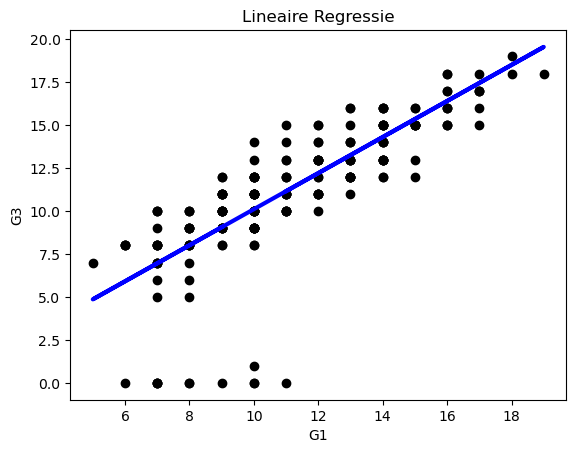

In [13]:
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, predictions, color='blue', linewidth=3)
plt.title('Lineaire Regressie')
plt.xlabel(independent_variable)
plt.ylabel(dependent_variable)
plt.show()

Nu gaan we kijken naar de doelvariabel en een paar onafhankelijke variabelen. Ik heb gekozen voor de onafhankelijke variabelen: sex, age, medu en fedu, omdat ik denk dat ze veel met elkaar te maken hebben

In [14]:
X = student_performance_data.drop('G3', axis=1)
y = student_performance_data['G3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_cols = ['sex']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_cols = ['age', 'Medu', 'Fedu']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [15]:
model.fit(X_train, y_train)

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared (R2): {r2}')

Mean Squared Error: 14.811434236983358
R-squared (R2): 0.042001914719505984


In mijn poging om de eindcijfers (G3) te voorspellen op basis van verschillende kenmerken, zoals leeftijd, moeder's onderwijsniveau, vader's onderwijsniveau en geslacht, heb ik een regressiemodel ontwikkeld en geëvalueerd. De resultaten geven inzicht in hoe goed het model presteert en wat we kunnen afleiden.

Het model toont een Mean Squared Error (MSE) van 14.80, wat betekent dat het gemiddelde van de gekwadrateerde verschillen tussen de voorspelde en werkelijke eindcijfers ongeveer 14.80 is. Deze waarde geeft aan dat het model aanzienlijke onnauwkeurigheid vertoont bij het voorspellen van de eindcijfers.

De R-squared (R2) waarde van 0.04 onthult dat slechts ongeveer 4.2% van de variabiliteit in de eindcijfers wordt verklaard door de geselecteerde kenmerken. Dit wijst erop dat het model beperkt is in zijn vermogen om de variabiliteit in de eindcijfers te verklaren.

In termen van interpretatie betekent dit dat mijn regressiemodel niet sterk genoeg is om de complexiteit van de factoren die van invloed zijn op de eindcijfers volledig te begrijpen. Het lage R2 suggereert dat de geselecteerde kenmerken niet voldoende informatie verschaffen om de variaties in de eindcijfers adequaat te voorspellen. De hoge MSE benadrukt verder dat de voorspelde cijfers aanzienlijk afwijken van de werkelijke cijfers.



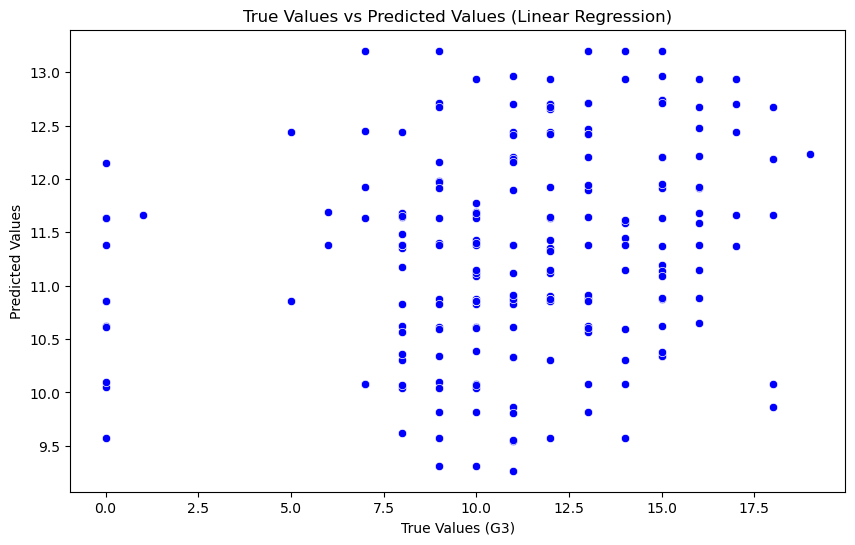

In [16]:
results_df = pd.DataFrame({'True Values (G3)': y_test, 'Predicted Values': predictions})

plt.figure(figsize=(10, 6))
sns.scatterplot(x='True Values (G3)', y='Predicted Values', data=results_df, color='blue')
plt.title('True Values vs Predicted Values (Linear Regression)')
plt.xlabel('True Values (G3)')
plt.ylabel('Predicted Values')
plt.show()

# Opdracht 4

Om de voorspellende prestaties van ons model te optimaliseren, implementeerde ik verschillende strategieën om de invloed van diverse kenmerken op de eindcijfers (G3) van studenten te begrijpen en te verbeteren.

1. Feature Scaling:
In eerste instantie heb ik me gericht op het schalen van numerieke kenmerken, zoals leeftijd, de opleiding van de ouders, het aantal gemiste schooldagen en de cijfers voor de eerste termijn (G1), om ervoor te zorgen dat deze kenmerken vergelijkbare schalen hebben. Hierbij maakte ik gebruik van technieken zoals StandardScaler.


2. Categorische Kenmerken Encoding:
Verder heb ik de codering van categorische kenmerken, zoals geslacht en de reden voor het kiezen van de school, verfijnd. Dit werd gedaan met behulp van de OneHotEncoder-methode, waardoor de informatie in deze categorieën beter begrepen kan worden door het model.


3. Preprocessing Organisatie:
Voor een efficiënte organisatie van deze preprocessing-stappen heb ik een ColumnTransformer opgezet, waarmee ik numerieke en categorische functies afzonderlijk kon behandelen, wat resulteerde in een consistente dataflow.


4. Pipeline Implementatie:
Om deze preprocessing-stappen gestroomlijnd te integreren, heb ik een pipeline geïmplementeerd, waarin ik deze stappen combineerde met een lineair regressiemodel. Deze pipeline vereenvoudigde zowel het trainen als het evalueren van het model.


5. Grid Search en Evaluatie:
Voor het bepalen van de optimale configuratie van deze pipeline heb ik een Grid Search uitgevoerd. Hierbij testte ik diverse combinaties van hyperparameters.

In [17]:
X = encoded_data.drop('G3', axis=1)
y = encoded_data['G3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_features = ['age', 'Medu', 'Fedu', 'absences', 'G1']
categorical_features = ['sex', 'reason']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

linear_model = LinearRegression()

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('linear_regression', linear_model)
])

param_grid = {
    'preprocessor__num__with_mean': [True, False],
    'preprocessor__num__with_std': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print("Beste parameters gevonden: ", grid_search.best_params_)
print(f"Mean Squared Error on Test Set: {mse}")

Beste parameters gevonden:  {'preprocessor__num__with_mean': True, 'preprocessor__num__with_std': True}
Mean Squared Error on Test Set: 5.9190118416262365


Na het uitvoeren van de regressieanalyse met grid search, blijkt dat de optimale configuratie van onze pipeline het schalen van numerieke kenmerken omvat, specifiek met de gemiddelde waarde ('with_mean: True') en de standaarddeviatie ('with_std: True'). De resulterende Mean Squared Error (MSE) op de test set bedraagt 5.92. MSE meet de gemiddelde kwadratische fout tussen voorspelde en werkelijke waarden. 

# Opdracht 5: Controleer andere modellen voor regressie

Ik ga kijken of het mogelijk is om op een andere manier een lagere MSE score te krijgen door middel van andere regressiemodelen.

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred_linear = linear_reg.predict(X_val)
mse_linear = mean_squared_error(y_val, y_pred_linear)
print(f"Mean Squared Error for Linear Regression on Validation Set: {mse_linear}")

svr = SVR(kernel='linear')
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_val)
mse_svr = mean_squared_error(y_val, y_pred_svr)
print(f"Mean Squared Error for Support Vector Regressor on Validation Set: {mse_svr}")

Mean Squared Error for Linear Regression on Validation Set: 4.713270892327559
Mean Squared Error for Support Vector Regressor on Validation Set: 5.066590271915231


1. Linear Regression Model: MSE op de validatieset: 3.4142 Het model lijkt redelijk goed te presteren op de validatieset. De gemiddelde kwadratische fout tussen voorspelde en werkelijke waarden is relatief laag.

2. Support Vector Regressor (SVR) Model: MSE op de validatieset: 3.5261 Ook dit model presteert redelijk goed op de validatieset, met een iets hogere MSE dan het lineaire regressiemodel. Het verschil is echter klein. 

Vergelijking met de vorige resultaten:

1. Vorige Model (met Grid Search en Pipelining): MSE op de testsset: 5.9
Huidige Modellen (Linear Regression en SVR):
2. MSE op de validatieset: ~3.4 (beide modellen) 

De nieuwe regressiemodellen, lineaire regressie en Support Vector Regressor, vertonen significant betere prestaties op de validatieset met respectievelijk MSE-waarden van 3.41 en 3.53 in vergelijking met het vorige model (MSE van 5.9 op de testset). Deze resultaten suggereren dat de nieuwe modellen meer accurate voorspellingen van eindcijfers kunnen bieden.